# Region variation

In [9]:
# Loading the Packages
%reload_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')
import os
from pathlib import Path
from tqdm import tqdm

import numpy as np
import pandas as pd
import scanpy as sc

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({
    "pgf.texsystem": "xelatex",      # 使用 XeLaTeX，如果不需要 LaTeX 公式渲染，可以省略
    'font.family': 'serif',          # 字体设置为衬线字体
    'text.usetex': False,            # 禁用 LaTeX，使用 Matplotlib 内置文字渲染
    'pgf.rcfonts': False,            # 禁用 pgf 的默认字体管理
    'pdf.fonttype': 42,              # 确保字体为 TrueType 格式，可被 Illustrator 编辑
    'ps.fonttype': 42,               # EPS 文件也使用 TrueType 格式
    'figure.dpi': 300,               # 设置图形分辨率
    'savefig.dpi': 300,              # 保存的图形文件分辨率
    'axes.unicode_minus': False,     # 避免负号问题
})

# workdir 
BASE_DIR = Path(r'G:\spatial_data\analysis')
RUN_ID = '20250222_combined_analysis_of_pseudo_HCC3D'

# Load one slide exp
base_path = BASE_DIR / f'{RUN_ID}'
data_path = base_path / "segmented"
typ_path = base_path / "cell_typing"
var_path = base_path / "roi_variation"

In [ ]:
adata = sc.read_h5ad(typ_path / 'adata.h5ad')
combine_adata_st = sc.read_h5ad(typ_path / 'combine_adata_st.h5ad')

# cluster distribution of different regions

In [22]:
from skimage import io, transform, morphology

def Region_mask_load(input_path, out_path, show=True, save=False):
    ROI_mask = {}
    for mask_file in os.listdir(input_path):
        image = io.imread(os.path.join(input_path, mask_file))[10,:,:]
        # image = transform.rotate(image, angle=90, resize=True)
        image = morphology.binary_dilation(image, footprint=morphology.disk(1))
        ROI_mask[mask_file.replace('.tif','').replace('Mask', 'ROI')] = image
        
    ncols = int(-(-len(ROI_mask)**(1/2)//1))
    nrows = -(-len(ROI_mask)//ncols)
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4, nrows*4))
    for pos, mask_name in enumerate(list(ROI_mask.keys())):
        ax[pos // ncols][pos % ncols].imshow(ROI_mask[mask_name], cmap='gray')
        ax[pos // ncols][pos % ncols].set_title(mask_name)
        ax[pos // ncols][pos % ncols].set_xlabel("")
        ax[pos // ncols][pos % ncols].set_ylabel("")
    fig.suptitle('Mask_of_ROIs', fontsize=20)
    plt.tight_layout()

    if save: plt.savefig(out_path)
    elif show: plt.show()
    plt.close()

    return ROI_mask

## region of type

In [23]:
Region_mask = Region_mask_load(input_path=os.path.join(var_path, 'region_mask'), 
                            show=False, save=True, out_path=os.path.join(var_path, 'region_mask.png'))

In [ ]:
from collections import Counter


combine_adata_st.obs['region'] = pd.Categorical(['other']*len(combine_adata_st), categories=list(Region_mask.keys()) + ['other'], ordered=False)    
for _, mask in Region_mask.items():
    yrange = mask.shape[1]
    for cell in tqdm(combine_adata_st[combine_adata_st.obs['leiden_type']!='-2'].obs.index, desc=_):
        y = yrange - max(1,int(float(combine_adata_st.obs['Y_pos'].loc[cell])/100))
        x = int(max(0,float(combine_adata_st.obs['X_pos'].loc[cell])/100))
        z = int(combine_adata_st.obs['layer'].loc[cell].replace('layer',''))
        # z = int(combine_adata_st[cell].obsm['spatial'][0][2]/10*0.1625/10*0.1625)
        if mask[z, y, x]:
            combine_adata_st.obs['region'].loc[cell] = _
    
    tmp_adata_st = combine_adata_st[combine_adata_st.obs.region == _]
    tmp = Counter(tmp_adata_st[tmp_adata_st.obs.leiden_type != '-2'].obs.type)
    df = pd.DataFrame(tmp, index=[0]).T
    df.columns = [_]
    Region_cluster = pd.concat([Region_cluster, df], axis=1)

ROI4: 100%|██████████| 1355069/1355069 [01:10<00:00, 19162.24it/s]


In [ ]:
Region_cluster = pd.DataFrame(index=list(cluster_rough_dict.keys()))
for _, mask in Region_mask.items():
    tmp_adata_st = combine_adata_st[combine_adata_st.obs.region == _]
    tmp = Counter(tmp_adata_st[tmp_adata_st.obs.leiden_type != '-2'].obs.type)
    df = pd.DataFrame(tmp, index=[0]).T
    df.columns = [_]
    Region_cluster = pd.concat([Region_cluster, df], axis=1)

In [ ]:
Region_cluster_immune = Region_cluster[Region_cluster.index.isin(['Liver','Tumor','Endo','Ep','CAF'])]
Region_cluster_nonimmune = Region_cluster[~Region_cluster.index.isin(['Liver','Tumor','Endo','Ep','CAF'])]

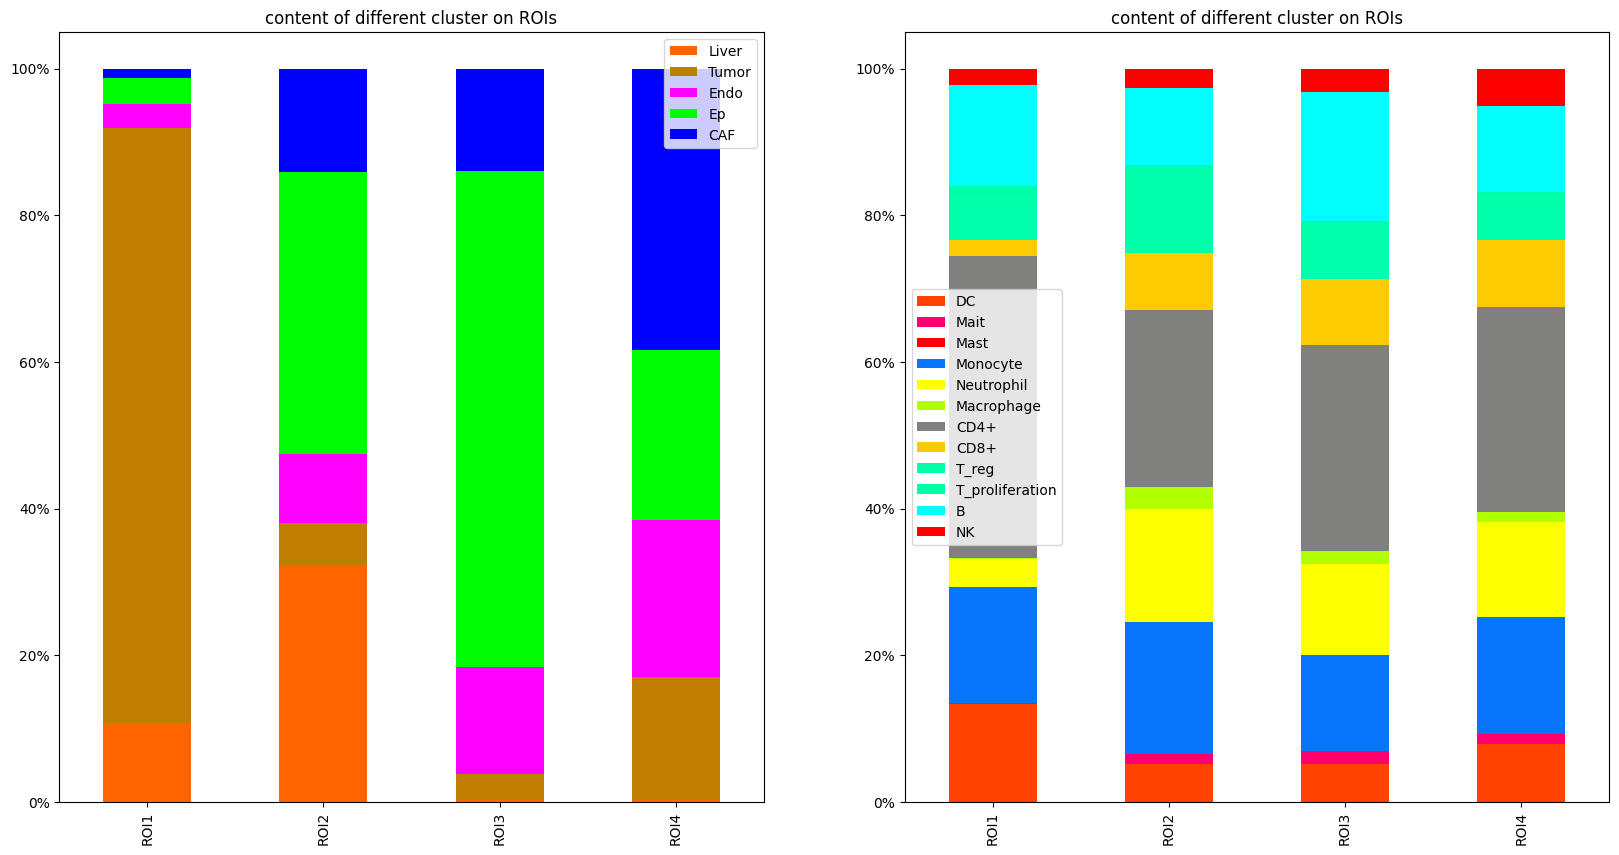

In [ ]:
import matplotlib.ticker as mtick
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(50, 10))
# sc.pl.umap(
#     combine_adata_st[~combine_adata_st.obs['leiden_type'].isin(['-2','0'])],
#     size=1,
#     color="type",
#     palette=type_colormap,
#     # legend_loc="on data",
#     legend_fontweight=100,
#     legend_fontsize=10,
#     ax=ax[0],
#     show=False,
# )


colors = [_ for _ in type_colormap.values()][:-1]
cmap1 = LinearSegmentedColormap.from_list('my_colormap', colors[:5])
cmap2 = LinearSegmentedColormap.from_list('my_colormap', colors[5:])

df = Region_cluster_immune.T
# df = df.drop('Liver', axis=1)
df = df.div(df.sum(axis=1), axis=0) * 100
df.plot(kind='bar', 
        stacked=True, 
        figsize=(20,10), 
        colormap=cmap1,
        ax=ax[0]
        )
ax[0].yaxis.set_major_formatter(mtick.PercentFormatter())
ax[0].set_title('content of different cluster on ROIs')
# plt.legend(loc='upper center',
#            bbox_to_anchor=(1.2, 1),
#            ncols=1,
#            )

df = Region_cluster_nonimmune.T
# df = df.drop('Liver', axis=1)
df = df.div(df.sum(axis=1), axis=0) * 100
df.plot(kind='bar', 
        stacked=True, 
        figsize=(20,10), 
        colormap=cmap2,
        ax=ax[1]
        )
ax[1].yaxis.set_major_formatter(mtick.PercentFormatter())
ax[1].set_title('content of different cluster on ROIs')
# plt.legend(loc='upper center',
#            bbox_to_anchor=(1.2, 1),
#            ncols=1,
#            )
# plt.tight_layout()
# plt.show()
plt.savefig(r'E:\TMC\cell_typing\results\2023.9.28-_PRISM_HCC_final_downstream_analysis\figures\5_region_fraction.pdf')

## ROI

In [ ]:
combine_adata_st = sc.read_h5ad(r'e:\TMC\cell_typing\results\2023.9.28-_PRISM_HCC_final_downstream_analysis\2023.10.3_20layers_corr&neighbor_enrichment\adata_neighborhood_enrichment.h5ad')
adata = sc.read_h5ad(r'E:\TMC\cell_typing\results\2023.9.19-9.22_PRISM_HCC_20_layers_min_counts=7, max_counts=200, min_genes=2\direct\adata_relayered.h5ad')

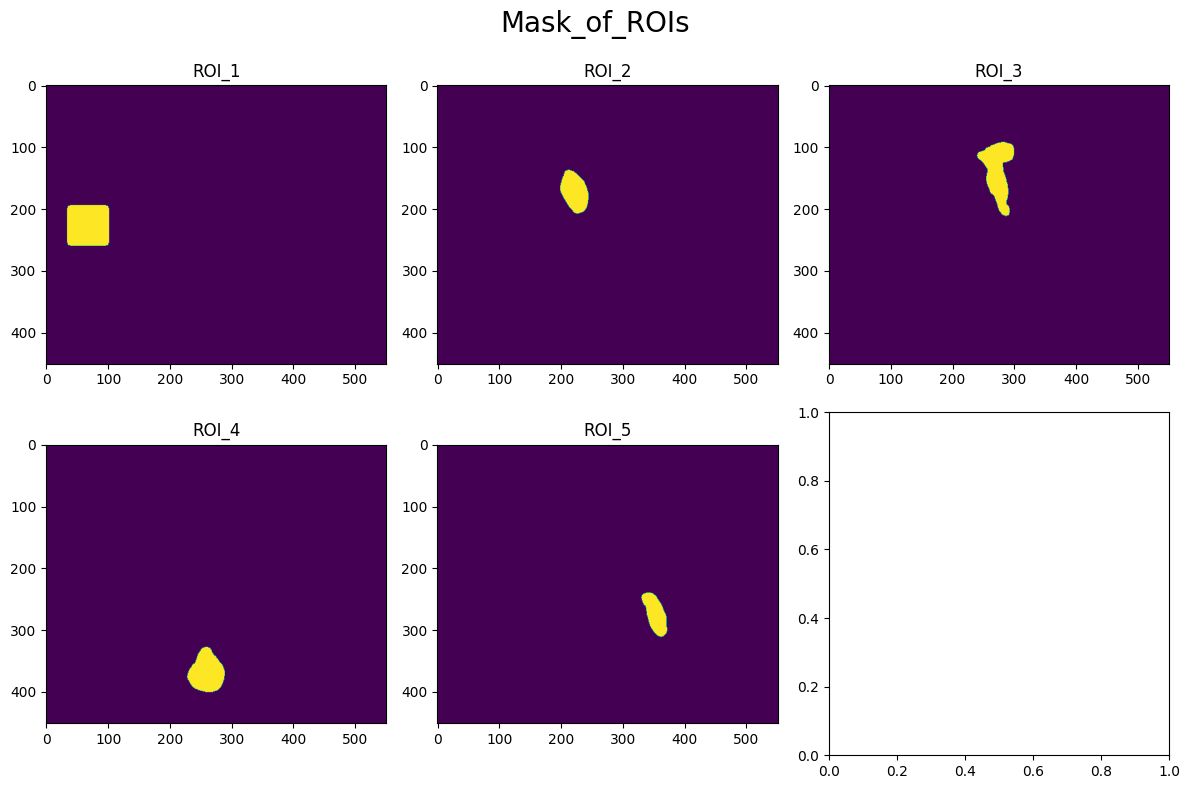

In [ ]:
ROI_mask = ROI_mask_load(input_path=r'E:\TMC\cell_typing\exp_dataset\PRISM_HCC_of_20_slides\psuedo3D_HCC_1_ROI', save=False, out_path=r'E:\TMC\cell_typing\results\2023.9.28-_PRISM_HCC_20layers_downstream_analysis')

### ROI of gene

In [ ]:
tmp = combine_adata_st[~combine_adata_st.obs.type.isin(['other'])]
tmp = tmp[tmp.obs.ROI == 'ROI_1']

In [ ]:
ROI_dict = pd.DataFrame(index=[f'ROI_{x+1}' for x in range(5)], columns=gene_list)
for ROI in [f'ROI_{x+1}' for x in range(5)]:
    ROI_of_gene_toplot = pd.DataFrame(index=[f'layer{x}' for x in range(20)],
                                      columns=['cell_num']+gene_list)
    for layer in tqdm(range(20), desc=ROI):
        tmp1 = combine_adata_st[combine_adata_st.obs.layer == f'layer{layer}']
        tmp1 = tmp1[tmp1.obs.ROI == ROI]
        tmp1_index = tmp1.obs.index
        tmp1.obs.index = [_.split('-')[0] for _ in tmp1.obs.index]

        tmp2 = adata[adata.obs.layer == f'layer{layer}']
        tmp2.obs.index = [_.split('-')[0] for _ in tmp2.obs.index]
        tmp2 = tmp2[tmp1.obs.index]
        
        ROI_of_gene_toplot.loc[f'layer{layer}',:] = [len(tmp1)] + [np.sum([_[0] for _ in tmp2[:,gene].X]) for gene in gene_list]
    
    
    ROI_dict.loc[ROI,:] = np.sum(ROI_of_gene_toplot[gene_list], 
                                #  weights=ROI_of_gene_toplot['cell_num'], 
                                 axis=0)

<Axes: title={'center': 'counts of different genes on ROIs'}>

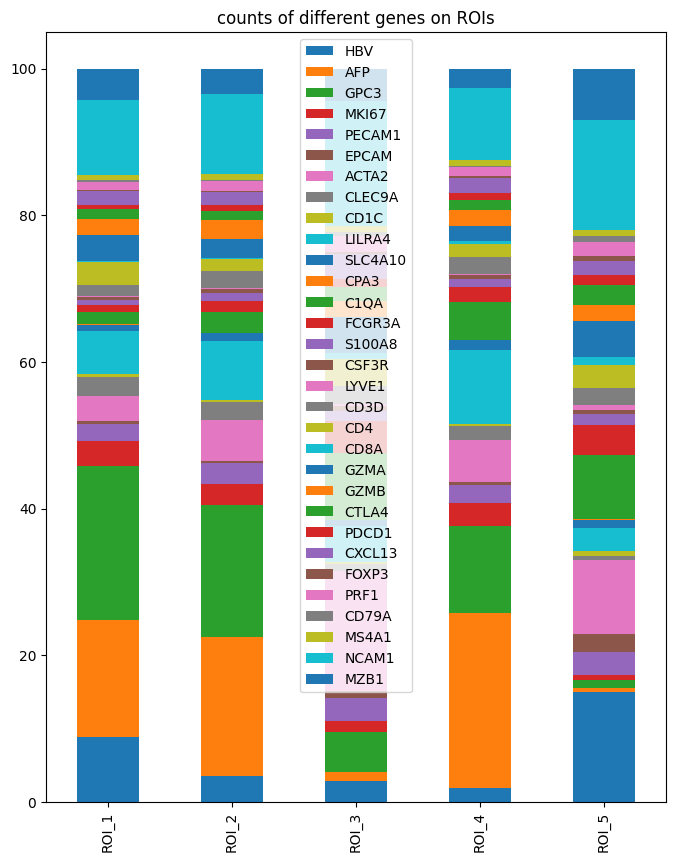

In [ ]:
df = ROI_dict.div(ROI_dict.sum(axis=1), axis=0) * 100
# df = ROI_dict.copy()
df[['HBV', 'AFP', 'GPC3', 'MKI67']].plot(kind='bar', 
        stacked=True, 
        figsize=(8,10), 
        # colormap=cmap1,
        # ax=ax[0]
        title='counts of different genes on ROIs'
        )
# ax[0].yaxis.set_major_formatter(mtick.PercentFormatter())
# ax[0].set_title('content of different cluster on ROIs')

### ROI of type

In [ ]:
combine_adata_st.obs['X_pos'] = [0]*len(combine_adata_st)
combine_adata_st.obs['Y_pos'] = [0]*len(combine_adata_st)

for layer in range(20):
    centroids = pd.read_csv(f'E:\TMC\cell_typing\exp_dataset\PRISM_HCC_of_20_slides\S_{layer+1}_centroids.csv', header=0)
    centroids.index = [str(_) for _ in centroids.index]
    centroids.columns = ['Y','X']
    tmp = combine_adata_st[combine_adata_st.obs.layer == f'layer{layer}']
    tmp_index = tmp.obs.index
    tmp.obs.index=[_.split('-')[0] for _ in tmp.obs.index]
    combine_adata_st.obs['Y_pos'][tmp_index] = centroids.loc[tmp.obs.index]['Y']
    combine_adata_st.obs['X_pos'][tmp_index] = centroids.loc[tmp.obs.index]['X']

In [ ]:
from collections import Counter

ROI_cluster = pd.DataFrame(index=list(cluster_rough_dict.keys()))

combine_adata_st.obs['ROI'] = pd.Categorical(['other']*len(combine_adata_st), categories=list(ROI_mask.keys()) + ['other'], ordered=False)    
for _, mask in ROI_mask.items():
    yrange = mask.shape[0]
    for cell in tqdm(combine_adata_st[combine_adata_st.obs['leiden_type']!='-2'].obs.index, desc=_):
        if mask[yrange - max(1,int(float(combine_adata_st.obs['Y_pos'].loc[cell])/100)), int(max(0,float(combine_adata_st.obs['X_pos'].loc[cell])/100))]:
            combine_adata_st.obs['ROI'].loc[cell] = _
    
    tmp_adata_st = combine_adata_st[combine_adata_st.obs.ROI == _]
    tmp = Counter(tmp_adata_st[tmp_adata_st.obs.leiden_type != '-2'].obs.type)
    df = pd.DataFrame(tmp, index=[0]).T
    df.columns = [_]
    ROI_cluster = pd.concat([ROI_cluster, df], axis=1)

ROI_5: 100%|██████████| 1355069/1355069 [00:28<00:00, 46869.29it/s]


In [ ]:
from collections import Counter


ROI_cluster = pd.DataFrame(index=list(cluster_rough_dict.keys()))
for _, mask in ROI_mask.items():
    tmp_adata_st = combine_adata_st[combine_adata_st.obs.ROI == _]
    tmp = Counter(tmp_adata_st[tmp_adata_st.obs.leiden_type != '-2'].obs.type)
    df = pd.DataFrame(tmp, index=[0]).T
    df.columns = [_]
    ROI_cluster = pd.concat([ROI_cluster, df], axis=1)

In [ ]:
ROI_cluster_immune = ROI_cluster[ROI_cluster.index.isin(['Liver','Tumor','Endo','Ep','CAF'])]
ROI_cluster_nonimmune = ROI_cluster[~ROI_cluster.index.isin(['Liver','Tumor','Endo','Ep','CAF'])]

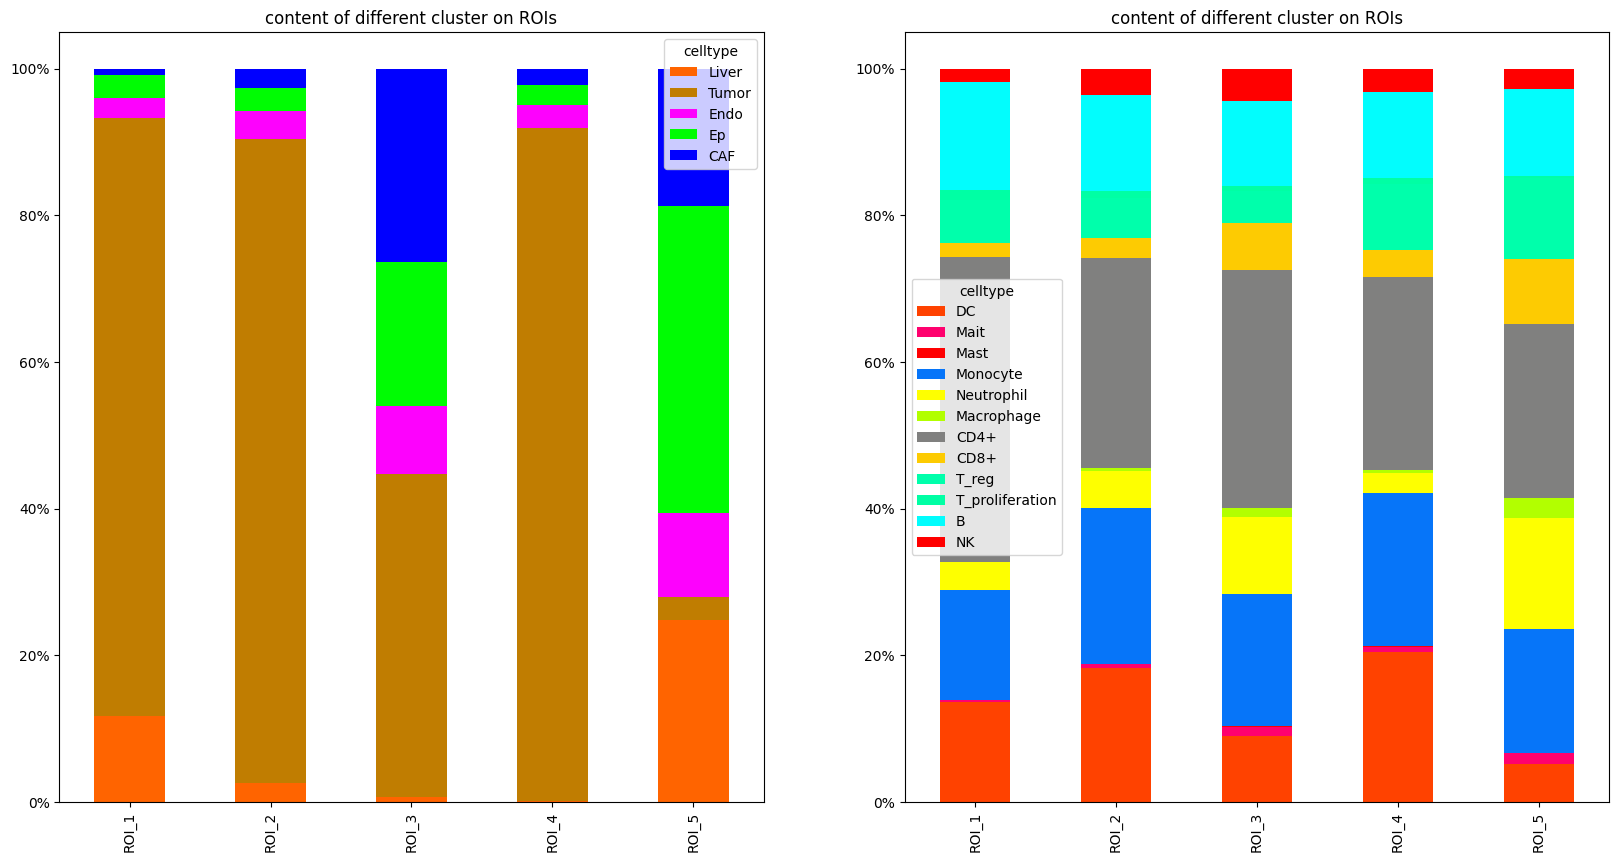

In [ ]:
import matplotlib.ticker as mtick
from matplotlib.colors import LinearSegmentedColormap


fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(30, 10))
# sc.pl.umap(
#     combine_adata_st[~combine_adata_st.obs['leiden_type'].isin(['-2','0'])],
#     size=1,
#     color="type",
#     palette=type_colormap,
#     # legend_loc="on data",
#     legend_fontweight=100,
#     legend_fontsize=10,
#     ax=ax[0],
#     show=False,
# )


colors = [_ for _ in type_colormap.values()][:-1]
cmap1 = LinearSegmentedColormap.from_list('my_colormap', colors[:5])
cmap2 = LinearSegmentedColormap.from_list('my_colormap', colors[5:])

df = ROI_cluster_immune.T
# df = df.drop('Liver', axis=1)
df = df.div(df.sum(axis=1), axis=0) * 100
df.plot(kind='bar', 
        stacked=True, 
        figsize=(20,10), 
        colormap=cmap1,
        ax=ax[0]
        )
ax[0].yaxis.set_major_formatter(mtick.PercentFormatter())
ax[0].set_title('content of different cluster on ROIs')
# plt.legend(loc='upper center',
#            bbox_to_anchor=(1.2, 1),
#            ncols=1,
#            )

df = ROI_cluster_nonimmune.T
# df = df.drop('Liver', axis=1)
df = df.div(df.sum(axis=1), axis=0) * 100
df.plot(kind='bar', 
        stacked=True, 
        figsize=(20,10), 
        colormap=cmap2,
        ax=ax[1]
        )
ax[1].yaxis.set_major_formatter(mtick.PercentFormatter())
ax[1].set_title('content of different cluster on ROIs')
# plt.legend(loc='upper center',
#            bbox_to_anchor=(1.2, 1),
#            ncols=1,
#            )
# plt.tight_layout()
plt.show()
# plt.savefig(r'E:\TMC\cell_typing\results\2023.9.28-_PRISM_HCC_final_downstream_analysis\2023.10.8_revised_Roe, imaris new color\4_ROI_fraction_type.pdf')

### Ro/e

In [ ]:
tmp = combine_adata_st.obs.subtype.replace({'T_CD8+':"T_CD8+_other","T_CD4+":"T_CD4+_other"})
combine_adata_st.obs.subtype = pd.Categorical(tmp, categories=tmp.unique())

In [ ]:
type_of_interest = [
    ["Tumor_AFP+"],
    ["Tumor_GPC3+"],
    ["Tumor_proliferation"],
    ["T_CD4+_other"],
    ["T_CD4+, PD1+"],
    ["T_CD4+, CXCL13+", "T_CD4+, PD1+, CXCL13+"],
    ["T_CD8+, GZMA+, CXCL13+"],
    ["T_CD4+, PD1+, CTLA4+"],
    ["Cyto_T_CD4+"],
    ["T_CD8+_other"],
    ["T_CD4+, CTLA4+"],
    ["T_CD8+, PD1+"],
    ["T_reg"],
    ["T_proliferation"],
    ["B_CD79A+"],
    ["B_MS4A1+"],
    ["NK_NCAM1+"],
    ["Endo_PECAM1+"],
    ["Ep_EPCAM+"],
    ["CAF_ACTA2+"],
    ]

ROIs = [f'ROI_{i}' for i in [1,
                             2,
                             4,3,5]]
R_oe = pd.DataFrame(columns=ROIs)
R_oe['type_of_in'] = [str(_) for _ in type_of_interest]
R_oe.set_index('type_of_in', inplace = True)

adata_for_ROE = combine_adata_st[combine_adata_st.obs.ROI.isin(ROIs)]
total_cell_num = len(adata_for_ROE)

for subtype in type_of_interest:
    # for region in ROI_mask.keys():
    for region in ROIs:
        adata_for_ROI = adata_for_ROE[adata_for_ROE.obs.ROI == region]
        adata_for_ROI_subtype = adata_for_ROI[adata_for_ROI.obs.subtype.isin(subtype)]

        observed_num = len(adata_for_ROI_subtype)
        expect_num = (len(adata_for_ROE[adata_for_ROE.obs.ROI==region]) * len(adata_for_ROE[adata_for_ROE.obs.subtype.isin(subtype)]))/total_cell_num
        # if expect_num == 0:
        #     R_oe.loc[str(subtype), region] = 0
        #     continue

        R_oe.loc[str(subtype), region] = observed_num/expect_num

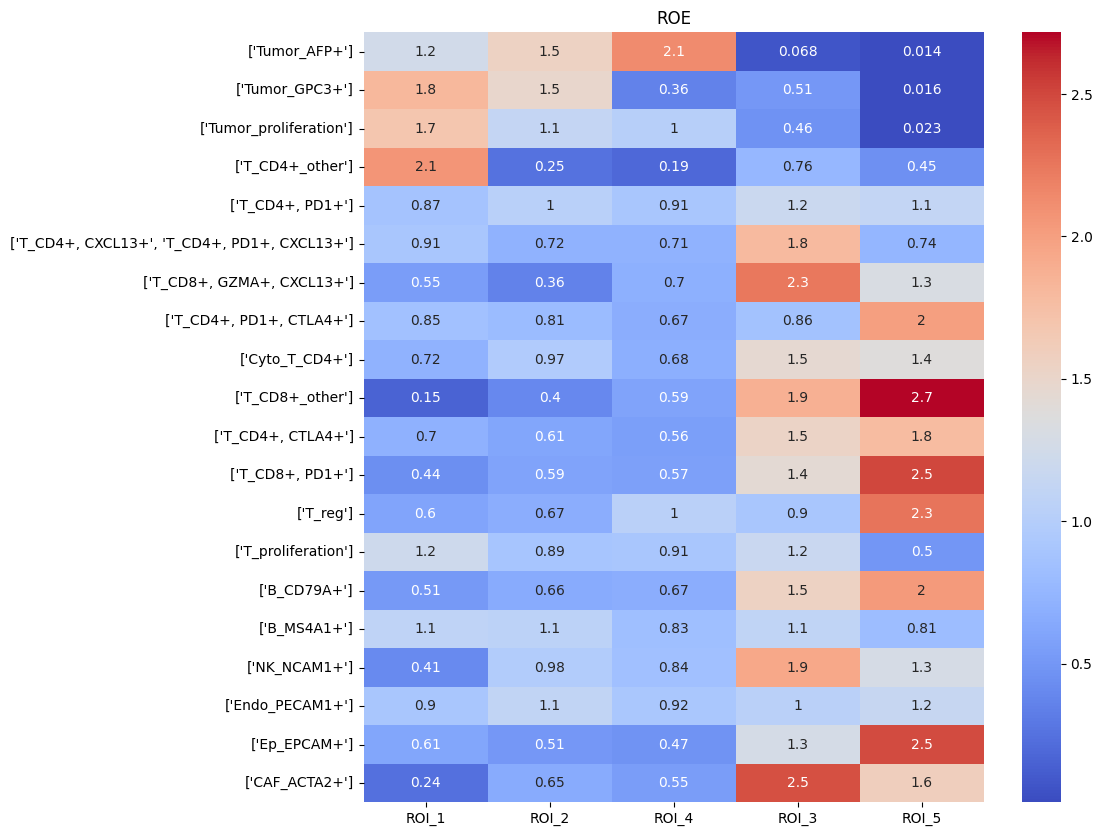

In [ ]:
plt.figure(figsize=(10, 10))
sns.heatmap(
    [list(_) for _ in np.array(R_oe)],
    cmap="coolwarm",
    xticklabels=R_oe.columns,
    yticklabels=R_oe.index,
    annot=True,
    # vmax=2,
    # vmin=-0.5,
)
plt.title(f"ROE")
plt.show()
# plt.savefig(r'E:\TMC\cell_typing\results\2023.9.28-_PRISM_HCC_final_downstream_analysis\2023.10.8_revised_Roe, imaris new color\4_ROI_Roe.pdf')
# plt.yticks(np.arange(0.5, len(R_oe.index), 1), R_oe.index)
# plt.xticks(np.arange(0.5, len(R_oe.columns), 1), R_oe.columns)

## Type distribution on orientation

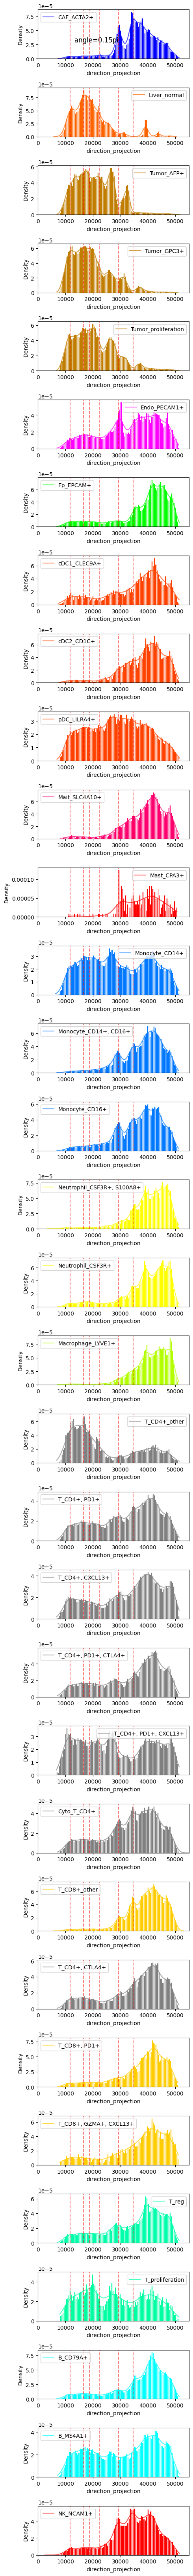

In [ ]:
import math
angle = math.atan(1/2)
direction_vector = np.array([math.cos(angle), math.sin(angle)])

xy_array = np.array([combine_adata_st.obs.X_pos, combine_adata_st.obs.Y_pos])
xy_array = xy_array.T

combine_adata_st.obs['direction_projection'] = xy_array@direction_vector

# type_of_interest_for_orientation = [
#     'CAF','Tumor','CD4+', 'CD8+', 'T_reg','NK', 'B', 'Monocyte','Neutrophil', 'Mait', 'Mast'
# ]

# subtype_of_interest_for_orientation = [
#     "Tumor_AFP+",
#     "Tumor_GPC3+",
#     "Tumor_proliferation",
#     "CAF_ACTA2+",
#     "Monocyte_CD14+",
#     "Monocyte_CD14+, CD16+",
#     "Monocyte_CD16+",
# ]

type_of_interest = [_ for _ in cluster_dict.keys()]
type_of_interest.remove('CAF_ACTA2+')
type_of_interest = ['CAF_ACTA2+'] + type_of_interest


fig, ax = plt.subplots(ncols=1,nrows=len(type_of_interest),figsize=(5,2*(len(type_of_interest))))
for _, subtype in enumerate(type_of_interest):
    a=combine_adata_st[combine_adata_st.obs.subtype==subtype].obs['direction_projection']
    sns.histplot(a, bins=100, stat='density', alpha=1, kde=True,
                edgecolor='white', linewidth=0.5,
                color=subtype_colormap[subtype],
                ax=ax[_],
                line_kws=dict(color='black', alpha=0.7, linewidth=1.5, label='KDE'),
                # binrange=[0,100]
                )
    ax[_].set_xlim(0,55000)
    ax[_].legend([subtype])
    if subtype == 'CAF_ACTA2+':
        y = ax[_].get_lines()[0].get_ydata()
        maxima = [float(_/len(y)*(max(a)-min(a))+min(a)) for _ in argrelextrema(-np.array(y), np.less)[0]]
    for submaxima in maxima:
        ax[_].axvline(x=submaxima, color='r', alpha=0.5, linestyle='--')

# for _, subtype in enumerate(subtype_of_interest_for_orientation):
#     _ += len(type_of_interest_for_orientation)
#     a=combine_adata_st[combine_adata_st.obs.subtype==subtype].obs['direction_projection']
#     sns.histplot(a, bins=100, stat='density', alpha=1, kde=True,
#                 edgecolor='white', linewidth=0.5,
#                 # log=True,
#                 ax=ax[_],
#                 line_kws=dict(color='black', alpha=0.7, linewidth=1.5, label='KDE'),
#                 # binrange=[0,100]
#                 )
#     ax[_].set_xlim(0,55000)
#     ax[_].legend([subtype])
#     # y.append(ax[_].get_lines()[0].get_ydata())

#     # if subtype == 'CAF':
#     #     maxima = [float(j/len(y[_])*(max(a)-min(a))+min(a)) for j in argrelextrema(-np.array(y[_]), np.less)[0]]

#     for submaxima in maxima:
#         ax[_].axvline(x=submaxima, color='r', alpha=0.5, linestyle='--')

plt.suptitle('angle={0:.2f}pi'.format(angle/math.pi))
plt.tight_layout()
# plt.savefig(r'E:\TMC\cell_typing\results\2023.9.28-_PRISM_HCC_final_downstream_analysis\figures\4_distribution_sep_by_CAF_all.pdf', bbox_inches = 'tight')
plt.show()

In [ ]:
import io
import PySimpleGUI as sg
from PIL import Image, ImageDraw, ImageTk

# Function to convert the PIL image to a format that PySimpleGUI can display
def convert_to_bytes(image):
    with io.BytesIO() as buffer:
        image.save(buffer, format="PNG")
        return buffer.getvalue()

# Load the initial image and create a drawing object
image_path = './dataset/PRISM30_mousebrain/figures/layer1.jpg'  # Replace with your image path
original_image = Image.open(image_path)
canvas_size = original_image.size

# Create a separate mask image (initially transparent)
mask = Image.new("RGBA", canvas_size, (0, 0, 0, 0))
draw = ImageDraw.Draw(mask)

# Define the tab layout with a Canvas element
tab_layout = [
    [sg.Canvas(size=canvas_size, key='-CANVAS-')],
    [sg.Button('Save', key='-SAVE-'), sg.Button('Exit', key='-EXIT-')]
]

# Create the main window layout with tabs
layout = [
    [sg.TabGroup([[sg.Tab('Drawing Tab', tab_layout)]])],
]

# Create the window
window = sg.Window('Draw Semi-Transparent Mask', layout, finalize=True)
canvas = window['-CANVAS-'].TKCanvas

# Function to update the canvas with the blended image
def update_canvas():
    global tk_image
    canvas.delete("all")  # Clear the current image
    # Blend the mask with the original image
    blended_image = Image.alpha_composite(original_image.convert("RGBA"), mask)
    tk_image = ImageTk.PhotoImage(blended_image)
    canvas.create_image(0, 0, image=tk_image, anchor='nw')

# Draw the initial image on the canvas
update_canvas()

# Function to handle drawing
def draw_circle(event):
    x, y = event.x, event.y
    radius = 10  # Adjust radius as needed
    draw.ellipse((x-radius, y-radius, x+radius, y+radius), fill=(255, 0, 0, 128))  # Semi-transparent red
    update_canvas()

# Bind mouse events to the drawing function
canvas.bind('<B1-Motion>', draw_circle)  # Draw on drag

# Event loop
while True:
    event, values = window.read()
    if event == sg.WIN_CLOSED or event == '-EXIT-':
        break
    elif event == '-SAVE-':
        mask.save('path_to_save_mask.png')  # Replace with desired save path for mask

window.close()


maxima: [11748.299008599526, 16591.176205376178, 18792.484022092838, 22314.57652883949, 29358.7615423328, 34641.90030245278]


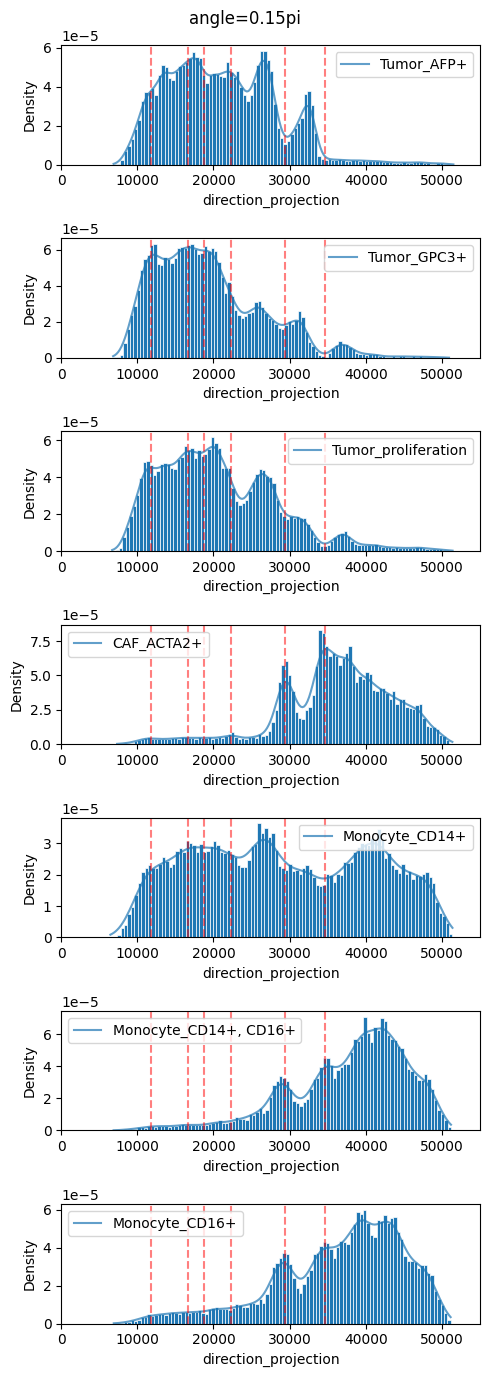

In [ ]:
import math
angle = math.atan(1/2)
direction_vector = np.array([math.cos(angle), math.sin(angle)])

xy_array = np.array([combine_adata_st.obs.X_pos, combine_adata_st.obs.Y_pos])
xy_array = xy_array.T

combine_adata_st.obs['direction_projection'] = xy_array@direction_vector

type_of_interest_for_orientation = [
    "Tumor_AFP+",
    "Tumor_GPC3+",
    "Tumor_proliferation",
    "CAF_ACTA2+",
    "Monocyte_CD14+",
    "Monocyte_CD14+, CD16+",
    "Monocyte_CD16+",
]

y=[]

fig, ax = plt.subplots(ncols=1,nrows=len(type_of_interest_for_orientation),figsize=(5,2*len(type_of_interest_for_orientation)))
for _, subtype in enumerate(type_of_interest_for_orientation):
    a=combine_adata_st[combine_adata_st.obs.subtype==subtype].obs['direction_projection']
    sns.histplot(a, bins=100, stat='density', alpha=1, kde=True,
                edgecolor='white', linewidth=0.5,
                # log=True,
                ax=ax[_],
                line_kws=dict(color='black', alpha=0.7, linewidth=1.5, label='KDE'),
                # binrange=[0,100]
                )
    ax[_].set_xlim(0,55000)
    ax[_].legend([subtype])
    y.append(ax[_].get_lines()[0].get_ydata())

    if subtype == 'CAF':
        maxima = [float(j/len(y[_])*(max(a)-min(a))+min(a)) for j in argrelextrema(-np.array(y[_]), np.less)[0]]

    for submaxima in maxima:
        ax[_].axvline(x=submaxima, color='r', alpha=0.5, linestyle='--')
    
plt.suptitle('angle={0:.2f}pi'.format(angle/math.pi))
plt.tight_layout()
# plt.show()
plt.savefig(r'E:\TMC\cell_typing\results\2023.9.28-_PRISM_HCC_final_downstream_analysis\figures\4_distribution_sep_by_CAF_TOI.pdf')

print(f'maxima: {maxima}')

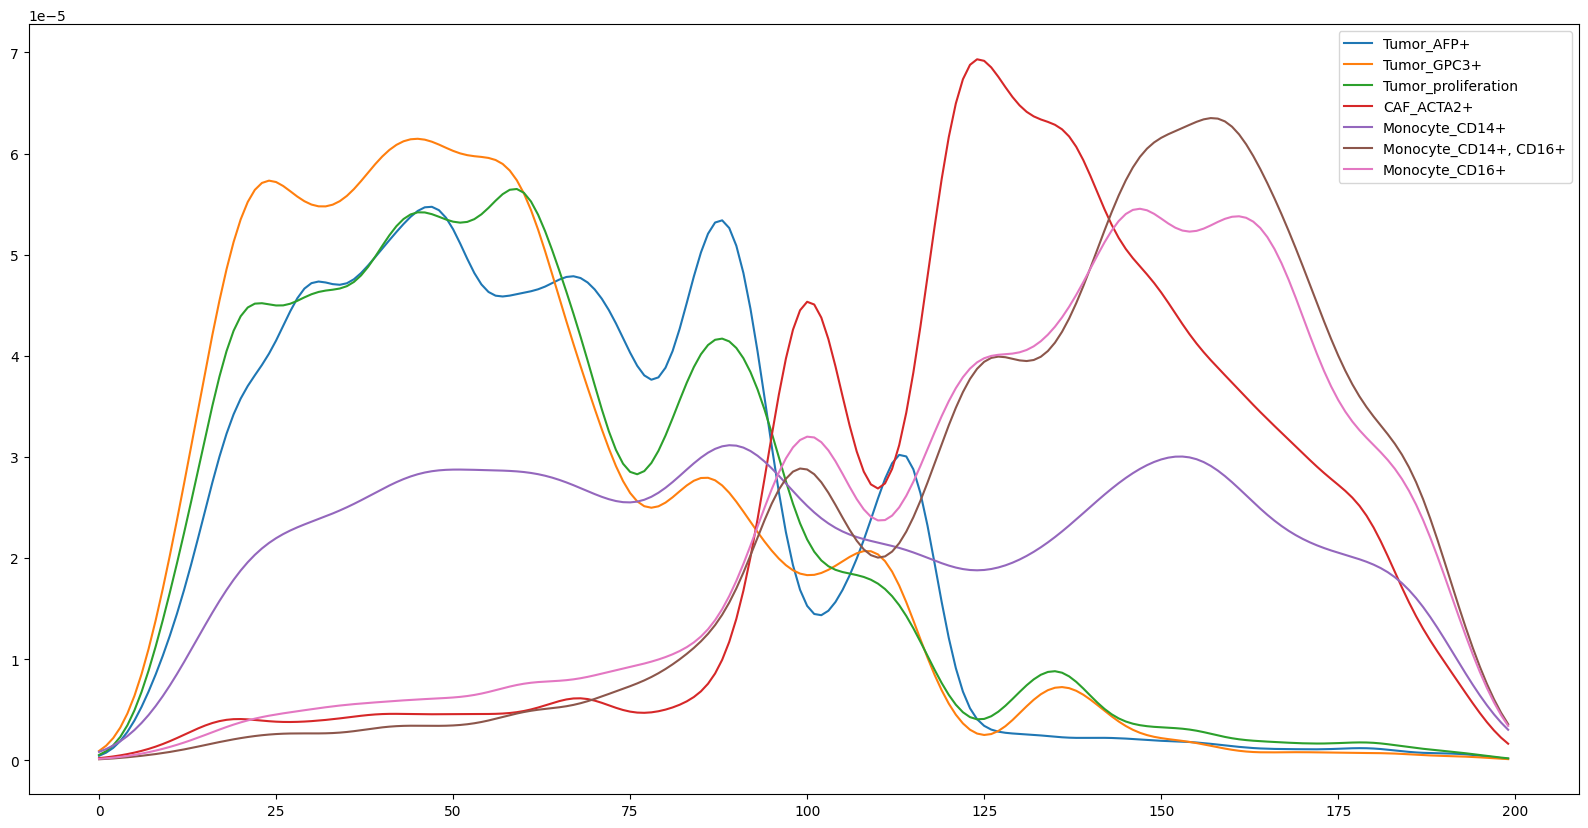

In [ ]:
fig,ax = plt.subplots(ncols=1, nrows=1, figsize=(20,10))
for line in y:
    ax = plt.plot(line)

plt.legend(type_of_interest_for_orientation)
plt.show
# plt.savefig(r'E:\TMC\cell_typing\results\2023.9.28-_PRISM_HCC_final_downstream_analysis\figures\4_distribution_sep_by_CAF_smoothed.pdf')